ref: https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/4_transformer.ipynb

In [1]:
!nvidia-smi

Fri Jun 17 16:37:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Graphics Device     On   | 00000000:01:00.0 Off |                    0 |
| N/A   44C    P0    67W / 275W |      0MiB / 81252MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  Graphics Device     On   | 00000000:47:00.0 Off |                    0 |
| N/A   

In [2]:
import functools
import sys

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm
import transformers

In [3]:
seed = 0

torch.manual_seed(seed)

In [4]:
train_data, test_data = datasets.load_dataset('imdb', split=['train', 'test'])

Reusing dataset imdb (/home/hyperai2/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
train_data

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

In [6]:
# transformer_name = 'bert-base-uncased'
transformer_name = 'bert-base-multilingual-cased'

tokenizer = transformers.AutoTokenizer.from_pretrained(transformer_name)

In [7]:
tokenizer.tokenize('hello world!')

['hell', '##o', 'world', '!']

In [8]:
tokenizer.encode('hello world!')

[101, 61694, 10133, 11356, 106, 102]

In [9]:
tokenizer.convert_ids_to_tokens(tokenizer.encode('hello world'))

['[CLS]', 'hell', '##o', 'world', '[SEP]']

In [10]:
tokenizer('hello world!')

{'input_ids': [101, 61694, 10133, 11356, 106, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [11]:
def tokenize_and_numericalize_data(example, tokenizer):
    ids = tokenizer(example['text'], truncation=True)['input_ids']
    return {'ids': ids}

In [12]:
train_data = train_data.map(tokenize_and_numericalize_data, fn_kwargs={'tokenizer': tokenizer})
test_data = test_data.map(tokenize_and_numericalize_data, fn_kwargs={'tokenizer': tokenizer})

Loading cached processed dataset at /home/hyperai2/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-f8dd1deb652b99e2.arrow


  0%|          | 0/25000 [00:00<?, ?ex/s]

In [13]:
pad_index = tokenizer.pad_token_id

In [14]:
pad_index

0

In [15]:
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data['train']
valid_data = train_valid_data['test']

In [16]:
train_data = train_data.with_format(type='torch', columns=['ids', 'label'])
valid_data = valid_data.with_format(type='torch', columns=['ids', 'label'])
test_data = test_data.with_format(type='torch', columns=['ids', 'label'])

In [17]:
train_data[0]

{'label': tensor(0),
 'ids': tensor([   101,  10747,  18379,  38106,  19118,    117,  10473,  27185,  23582,
          10107,  10105,  41807,  10108,  10105,  22818,  10813,  11366,    117,
          10189,    146,  10392,  62452,  11426,  10149,  93161,  10169,  28834,
          14010,    119,  15785,    146,  10392,  10273,    117,    146,  92147,
          11152,  10108,  10105,  11366,  10135,  17665,    169,  11695,  10635,
          36390,  10111,  10271,  10134,  84874,  13096,  10111,  41807,    119,
          48691,  10454,    117,  10531,  18379,  15107,  16745,  25791,  10114,
          10105,  11366,    119,    133,  33989,    120,    135,    133,  33989,
            120,    135,  10117,  14478,  21274,  10301,  16863,  13987,  15418,
          13167,    117,  10111,  10531,  65390,    112,    188,  20890,  10155,
          10105,  31307,  26665,    118,  11424,    119,  10117,  31810,  10379,
          10134,  10168,  11231,  10111,  23582,  10336,  11178,  15495,  10108,


In [18]:
transformer = transformers.AutoModel.from_pretrained(transformer_name)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
transformer.config.hidden_size

768

In [20]:
transformer.config

BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 119547
}

In [21]:
class Transformer(nn.Module):
    def __init__(self, transformer, output_dim, freeze):
        super().__init__()
        self.transformer = transformer
        hidden_dim = transformer.config.hidden_size
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        if freeze:
            for param in self.transformer.parameters():
                param.requires_grad = False
        
    def forward(self, ids):
        # ids = [batch size, seq len]
        output = self.transformer(ids, output_attentions=True)
        hidden = output.last_hidden_state
        # hidden = [batch size, seq len, hidden dim]
        attention = output.attentions[-1]
        # attention = [batch size, n heads, seq len, seq len]
        cls_hidden = hidden[:,0,:]
        prediction = self.fc(torch.tanh(cls_hidden))
        # prediction = [batch size, output dim]
        return prediction

In [22]:
output_dim = len(train_data['label'].unique())
freeze = False

model = Transformer(transformer, output_dim, freeze)

In [23]:
output_dim

2

In [24]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 177,854,978 trainable parameters


In [25]:
lr = 1e-5

optimizer = optim.Adam(model.parameters(), lr=lr)

In [26]:
criterion = nn.CrossEntropyLoss()

In [27]:
device = torch.device(1)

In [28]:
torch.cuda.get_arch_list()

['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86']

In [29]:
torch.__version__

'1.11.0+cu113'

In [30]:
model = model.to(device)
criterion = criterion.to(device)

In [31]:
criterion

CrossEntropyLoss()

In [32]:
def collate(batch, pad_index):
    batch_ids = [i['ids'] for i in batch]
    batch_ids = nn.utils.rnn.pad_sequence(batch_ids, padding_value=pad_index, batch_first=True)
    batch_label = [i['label'] for i in batch]
    batch_label = torch.stack(batch_label)
    batch = {'ids': batch_ids,
             'label': batch_label}
    return batch

In [33]:
batch_size = 8

collate = functools.partial(collate, pad_index=pad_index)

train_dataloader = torch.utils.data.DataLoader(train_data, 
                                               batch_size=batch_size, 
                                               collate_fn=collate, 
                                               shuffle=True)

valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, collate_fn=collate)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, collate_fn=collate)


In [34]:
def train(dataloader, model, criterion, optimizer, device):

    model.train()
    epoch_losses = []
    epoch_accs = []

    for batch in tqdm.tqdm(dataloader, desc='training...', file=sys.stdout):
        ids = batch['ids'].to(device)
        label = batch['label'].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

In [35]:
def evaluate(dataloader, model, criterion, device):
    
    model.eval()
    epoch_losses = []
    epoch_accs = []

    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc='evaluating...', file=sys.stdout):
            ids = batch['ids'].to(device)
            label = batch['label'].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

In [36]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [37]:
device

device(type='cuda', index=1)

In [38]:
n_epochs = 3
best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(n_epochs):

    train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, device)
    valid_loss, valid_acc = evaluate(valid_dataloader, model, criterion, device)

    train_losses.extend(train_loss)
    train_accs.extend(train_acc)
    valid_losses.extend(valid_loss)
    valid_accs.extend(valid_acc)
    
    epoch_train_loss = np.mean(train_loss)
    epoch_train_acc = np.mean(train_acc)
    epoch_valid_loss = np.mean(valid_loss)
    epoch_valid_acc = np.mean(valid_acc)
    
    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model.state_dict(), 'transformer.pt')
    
    print(f'epoch: {epoch+1}')
    print(f'train_loss: {epoch_train_loss:.3f}, train_acc: {epoch_train_acc:.3f}')
    print(f'valid_loss: {epoch_valid_loss:.3f}, valid_acc: {epoch_valid_acc:.3f}')

evaluating...: 100%|██████████████████████████| 782/782 [00:16<00:00, 47.45it/s]
epoch: 1
train_loss: 0.343, train_acc: 0.842
valid_loss: 0.235, valid_acc: 0.905
evaluating...: 100%|██████████████████████████| 782/782 [00:16<00:00, 47.43it/s]
epoch: 2
train_loss: 0.202, train_acc: 0.924
valid_loss: 0.317, valid_acc: 0.887
evaluating...: 100%|██████████████████████████| 782/782 [00:16<00:00, 47.44it/s]
epoch: 3
train_loss: 0.130, train_acc: 0.955
valid_loss: 0.270, valid_acc: 0.903


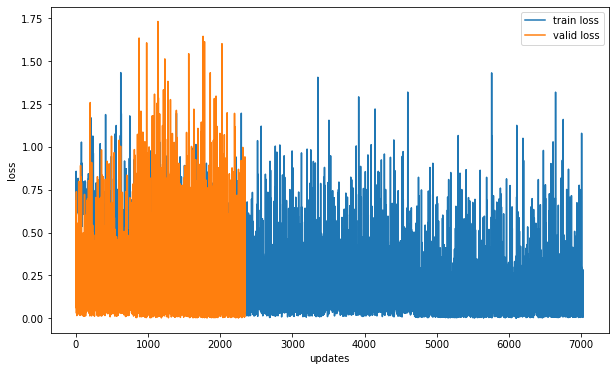

In [39]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_losses, label='train loss')
ax.plot(valid_losses, label='valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss');

In [40]:
model.load_state_dict(torch.load('transformer.pt'))

test_loss, test_acc = evaluate(test_dataloader, model, criterion, device)

epoch_test_loss = np.mean(test_loss)
epoch_test_acc = np.mean(test_acc)

print(f'test_loss: {epoch_test_loss:.3f}, test_acc: {epoch_test_acc:.3f}')

evaluating...: 100%|████████████████████████| 3125/3125 [01:04<00:00, 48.57it/s]
test_loss: 0.224, test_acc: 0.910


In [41]:
def predict_sentiment(text, model=model, tokenizer=tokenizer, device=device):
    ids = tokenizer(text)['input_ids']
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [42]:
predict_sentiment("This film is terrible!")

(0, 0.983956515789032)

In [43]:
predict_sentiment("This film is great!")

(1, 0.9897695779800415)

In [44]:
predict_sentiment("영화보면서 잠든건 또 처음이네 정말 짜증나 ㅠㅠ")

(0, 0.8016398549079895)

In [45]:
predict_sentiment("내 인생 최고의 영화였어!!!")

(1, 0.957915723323822)